# Scripts

## Imports

In [18]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import pandas as pd
from IPython.display import display, Markdown

random.seed(42)
np.random.seed(42)

## Bayesian Primality Test

In [ ]:
def gcd(a, b):
    """
    Compute the greatest common divisor of a and b using Euclidean algorithm.
    """
    while b:
        a, b = b, a % b
    return a

def power_mod(base, exponent, modulus):
    """
    Compute (base^exponent) % modulus efficiently using repeated squaring algorithm.
    This is much faster than the naive approach for large exponents.
    """
    if modulus == 1:
        return 0

    result = 1
    base = base % modulus

    while exponent > 0:
        # If exponent is odd, multiply result with base
        if exponent % 2 == 1:
            result = (result * base) % modulus

        # Divide the exponent by 2
        exponent = exponent >> 1  # Same as exponent // 2

        # Square the base
        base = (base * base) % modulus

    return result

def fermat_test(n, a):
    """
    Perform Fermat's primality test for a single witness 'a'.
    Returns:
    - True if n passes the test (might be prime)
    - False if n is definitely composite
    """
    # Edge cases
    if n <= 1:
        return False
    if n <= 3:
        return True
    if n % 2 == 0:
        return False

    # Check if a divides n
    if gcd(a, n) > 1:
        return False

    # Check Fermat's Little Theorem: a^(n-1) ≡ 1 (mod n)
    if power_mod(a, n-1, n) != 1:
        return False

    return True

def bayesian_primality_test(n, k=10, prior_probability=0.5):
    """
    Perform Fermat's primality test with k random witnesses,
    updating probability using Bayes' theorem.

    Parameters:
    - n: number to test for primality
    - k: number of random witnesses to test
    - prior_probability: prior belief that n is prime

    Returns:
    - final_probability: posterior probability that n is prime
    """
    # Handle edge cases
    if n <= 1:
        return 0.0

    if n <= 3:
        return 1.0

    if n % 2 == 0:
        return 0.0

    # Initialize current probability
    current_probability = prior_probability

    # Estimate probability of a composite number passing Fermat's test (using 1/2 as in the paper)
    p_pass_if_composite = 0.5

    for i in range(k):
        # Choose a random witness between 2 and n-2
        a = random.randint(2, n-2)

        # Perform the test
        test_passed = fermat_test(n, a)

        if test_passed:
            # Update using Bayes' theorem
            # P(prime|pass) = P(pass|prime) * P(prime) / P(pass)
            p_pass_given_prime = 1.0
            p_prime = current_probability
            p_composite = 1.0 - p_prime

            # P(pass) using law of total probability
            p_pass = (p_pass_given_prime * p_prime) + (p_pass_if_composite * p_composite)

            # Apply Bayes' theorem
            current_probability = (p_pass_given_prime * p_prime) / p_pass
        else:
            # If test fails, the number is definitely composite
            current_probability = 0.0
            break

    return current_probability

## Monte Carlo Verification of Prime Number Theorem

In [19]:
def monte_carlo_prime_theorem(j_values=range(2, 21), num_samples=10000, k=10, threshold=0.95):
    """
    Verify the Prime Number Theorem using Monte Carlo sampling for values x = e^j.

    Parameters:
    - j_values: range of j values for testing (x = e^j)
    - num_samples: number of random samples to test for each j
    - k: number of witnesses for the Bayesian primality test
    - threshold: probability threshold for declaring a number prime

    Returns:
    - results: list of dictionaries with experiment results
    """
    results = []

    for j in tqdm(j_values, desc="Testing j values from 2 to 20"):
        x = math.exp(j)
        num_primes = 0

        print(f"\nTesting j = {j}, x = e^{j} ≈ {x:.2f}")
        start_time = time.time()

        for i in range(num_samples):
            # Generate a random number from 2 to x (avoid 0, 1)
            sample = max(2, int(random.uniform(2, x)))

            # Use the Bayesian primality test with confidence threshold
            prob = bayesian_primality_test(sample, k=k)
            if prob >= threshold:
                num_primes += 1

        # Calculate proportions
        elapsed_time = time.time() - start_time
        sampled_proportion = num_primes / num_samples
        theoretical_proportion = 1 / math.log(x)

        # Calculate ratio and error
        ratio = sampled_proportion / theoretical_proportion
        error = abs(sampled_proportion - theoretical_proportion) / theoretical_proportion * 100

        result = {
            'j': j,
            'x': x,
            'sampled_proportion': sampled_proportion,
            'theoretical_proportion': theoretical_proportion,
            'ratio': ratio,
            'error': error,
            'time': elapsed_time
        }

        results.append(result)

        print(f"  Samples tested: {num_samples}")
        print(f"  Primes found: {num_primes}")
        print(f"  Sampled proportion: {sampled_proportion:.6f}")
        print(f"  Theoretical (1/ln(x)): {theoretical_proportion:.6f}")
        print(f"  Ratio: {ratio:.4f}")
        print(f"  Error: {error:.2f}%")
        print(f"  Time elapsed: {elapsed_time:.2f} seconds")

    return results

## Visualization

In [28]:
def plot_monte_carlo_results(results):
    """
    Plot the Monte Carlo results compared to theoretical predictions.

    Parameters:
    - results: List of dictionaries with experiment results

    Returns:
    - plt: Matplotlib figure object
    """
    plt.figure(figsize=(12, 8))

    # Extract data
    j_values = [result['j'] for result in results]
    x_values = [result['x'] for result in results]
    sampled_props = [result['sampled_proportion'] for result in results]
    theoretical_props = [result['theoretical_proportion'] for result in results]

    # Create comparison plot with log scale for x-axis
    plt.semilogx(x_values, theoretical_props, 'r-', linewidth=2, label='Theoretical: 1/ln(x)')
    plt.semilogx(x_values, sampled_props, 'bo', markersize=6, label='Monte Carlo Estimate')

    # Format plot
    plt.grid(True, which="both", ls="-")
    plt.xlabel('x = e^j')
    plt.ylabel('Proportion of Primes')
    plt.title('Monte Carlo Estimation vs. Theoretical Proportion')
    plt.legend()

    # Set y-axis limits with some margin
    plt.ylim(0, max(max(sampled_props), max(theoretical_props)) * 1.2)

    return plt


# Testing

In [32]:
def main():
    """Main execution function to verify the Prime Number Theorem."""
    print("Verifying the Prime Number Theorem using Monte Carlo sampling")
    print("===========================================================")
    print("This will estimate the proportion of primes for x = e^j where j ranges from 2 to 20")
    print("For each range, we'll sample random numbers and test primality using the Bayesian approach")
    print("Then we'll compare the results to the theoretical prediction from the Prime Number Theorem: 1/ln(x)")
    print("\nParameters:")
    print("- j values: 2 to 20")
    print("- Samples per range: 10,000")
    print("- Fermat test witnesses: 10")
    print("- Primality threshold: 0.95")
    print("\nStarting verification...\n")

    # Run Monte Carlo verification for j from 2 to 20
    results = monte_carlo_prime_theorem(
        j_values=range(2, 21),
        num_samples=10000,
        k=10,
        threshold=0.95
    )

    # Display results as a table
    print("\nSummary of Results:")
    df_results = pd.DataFrame(results)
    display(df_results[['j', 'x', 'theoretical_proportion', 'sampled_proportion', 'error', 'time']])

    # Create comparison plots
    print("\nGenerating visualization of results...")
    plot_monte_carlo_results(results).show()

    # Save results to CSV
    df_results.to_csv('prime_number_theorem_verification.csv', index=False)
    print("Results saved to prime_number_theorem_verification.csv")

    print("\nVerification completed!")

Verifying the Prime Number Theorem using Monte Carlo sampling
This will estimate the proportion of primes for x = e^j where j ranges from 2 to 20
For each range, we'll sample random numbers and test primality using the Bayesian approach
Then we'll compare the results to the theoretical prediction from the Prime Number Theorem: 1/ln(x)

Parameters:
- j values: 2 to 20
- Samples per range: 10,000
- Fermat test witnesses: 10
- Primality threshold: 0.95

Starting verification...



Testing different ranges:   0%|          | 0/19 [00:00<?, ?it/s]

j = 2, x = 7.4, Sampled: 0.6269, Theoretical: 0.5000, Error: 25.38%
j = 3, x = 20.1, Sampled: 0.4502, Theoretical: 0.3333, Error: 35.06%
j = 4, x = 54.6, Sampled: 0.2971, Theoretical: 0.2500, Error: 18.84%
j = 5, x = 148.4, Sampled: 0.2302, Theoretical: 0.2000, Error: 15.10%
j = 6, x = 403.4, Sampled: 0.1930, Theoretical: 0.1667, Error: 15.80%
j = 7, x = 1096.6, Sampled: 0.1663, Theoretical: 0.1429, Error: 16.41%
j = 8, x = 2981.0, Sampled: 0.1420, Theoretical: 0.1250, Error: 13.60%
j = 9, x = 8103.1, Sampled: 0.1260, Theoretical: 0.1111, Error: 13.40%
j = 10, x = 22026.5, Sampled: 0.1125, Theoretical: 0.1000, Error: 12.50%
j = 11, x = 59874.1, Sampled: 0.0994, Theoretical: 0.0909, Error: 9.34%
j = 12, x = 162754.8, Sampled: 0.0906, Theoretical: 0.0833, Error: 8.72%
j = 13, x = 442413.4, Sampled: 0.0877, Theoretical: 0.0769, Error: 14.01%
j = 14, x = 1202604.3, Sampled: 0.0815, Theoretical: 0.0714, Error: 14.10%
j = 15, x = 3269017.4, Sampled: 0.0696, Theoretical: 0.0667, Error: 4.40%


,j,x,theoretical_proportion,sampled_proportion,error,time
0,2,7.389056e+00,0.500000,0.6269,25.38,0.059396
1,3,2.008554e+01,0.333333,0.4502,35.06,0.064897
2,4,5.459815e+01,0.250000,0.2971,18.84,0.078001
3,5,1.484132e+02,0.200000,0.2302,15.10,0.057748
4,6,4.034288e+02,0.166667,0.1930,15.80,0.060696
5,7,1.096633e+03,0.142857,0.1663,16.41,0.064356
6,8,2.980958e+03,0.125000,0.1420,13.60,0.064801
7,9,8.103084e+03,0.111111,0.1260,13.40,0.063485
8,10,2.202647e+04,0.100000,0.1125,12.50,0.071250
9,11,5.987414e+04,0.090909,0.0994,9.34,0.075170



Generating visualization of results...


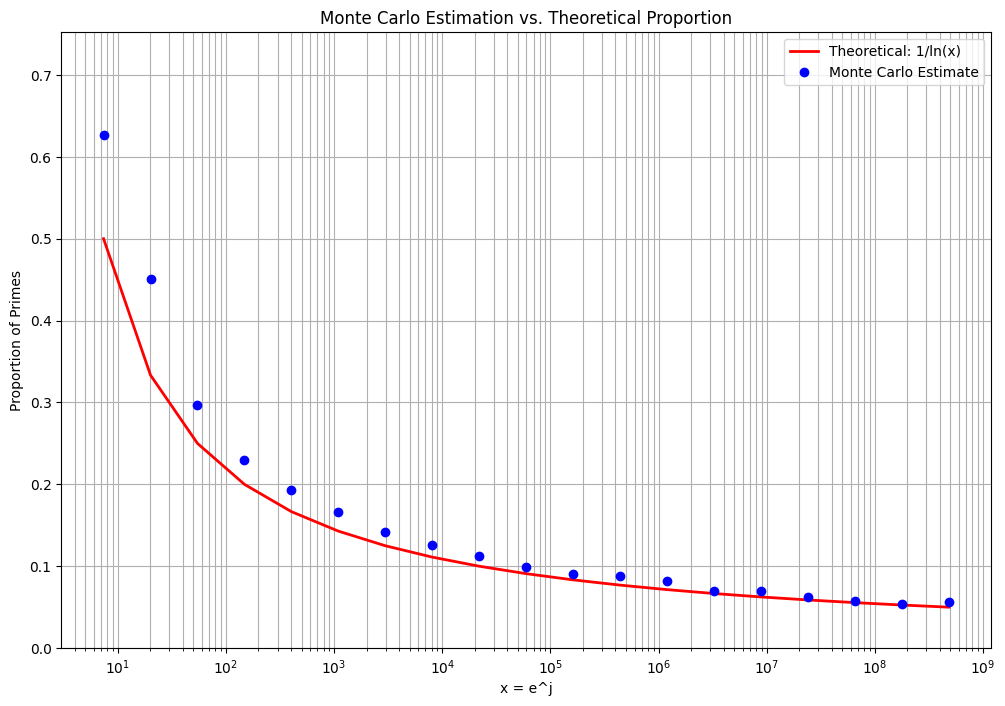

Results saved to prime_number_theorem_verification.csv

Verification completed!


In [33]:
main()